In [2]:
# Base Imports
import pandas as pd
import matplotlib.pyplot as plt

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Others
from tabulate import tabulate

# Boxplot
import seaborn as sns

In [3]:
# load in the testing feature_df
feature_df = pd.read_csv('feature_df.csv')

# Fake News vs. Official Communication

### Preprocessing
Note that we do not include plausibility here. 

In [4]:
# Select relevant features
feature_df = feature_df[['source','preprocessed','label', 'interestingness', 'sentiment_BERT',
                          'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 
                          'sentiment_vader', 'readability', 'lexical_diversity', 'superlatives', 'novelty', 
                          'average_word_length', 'plausibility', 'concreteness_lexical', 'valence_lexical', 
                          'dominance_lexical', 'arousal_lexical']]

# Select relevant features
feature_df_unique = feature_df[['source','preprocessed','label', 'interestingness',
                          'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 
                          'readability', 'lexical_diversity', 'superlatives', 'novelty', 
                          'average_word_length']]

In [5]:
# 8 times ChatGPT assigned non-existant labels, exclude them 
print(feature_df.isna().sum())
print(len(feature_df))

# 8 times ChatGPT assigned non-existant labels, exclude them 
print(feature_df_unique.isna().sum())
print(len(feature_df_unique))

source                    0
preprocessed              0
label                     0
interestingness           8
sentiment_BERT            0
sentiment_RoBERTa         0
concreteness              0
valence                   0
dominance                 0
arousal                   0
sentiment_vader           0
readability               0
lexical_diversity         0
superlatives              0
novelty                   0
average_word_length       0
plausibility              0
concreteness_lexical     57
valence_lexical         176
dominance_lexical       176
arousal_lexical         176
dtype: int64
28609
source                 0
preprocessed           0
label                  0
interestingness        8
sentiment_RoBERTa      0
concreteness           0
valence                0
dominance              0
arousal                0
readability            0
lexical_diversity      0
superlatives           0
novelty                0
average_word_length    0
dtype: int64
28609


In [6]:
# Display rows where 'valence_lexical' is NaN
nan_rows = feature_df[feature_df['valence_lexical'].isna()]
print(nan_rows['preprocessed'])

33       ['rt', 'cómo', 'usar', 'una', 'mascarilla', 'd...
192      ['lockdown', 'in', 'telangana', 'extended', 't...
235      ['assista', 'à', 'conferência', 'de', 'imprens...
514      ['coronavirus', 'cases', 'reported', 'in', 'ro...
527      ['h1n1', 'caused', 'more', 'deaths', 'during',...
                               ...                        
27612    ['spain', 'cancels', 'all', 'bullfights', 'mat...
27873                       ['ebspecial', 'on', 'covid19']
28067    ['india', 'scientists', 'found', 'that', 'the'...
28383    ['so', 'the', 'is', 'secretly', 'treating', 't...
28464    ['assista', 'à', 'conferência', 'de', 'imprens...
Name: preprocessed, Length: 176, dtype: object


In [7]:
feature_df = feature_df.dropna()
print(len(feature_df))

feature_df_unique = feature_df_unique.dropna()
print(len(feature_df_unique))

28425
28601


#### Testing Standardization and Normalization

In [8]:
# Define feature set and target variable
features = feature_df.columns.drop('label').drop('source').drop('preprocessed')
X = feature_df[features]
y = feature_df['label']

print(X)

       interestingness  sentiment_BERT  sentiment_RoBERTa  concreteness  \
0                  1.0               4                  1      0.652198   
1                  1.0               5                  1      0.642415   
2                  0.0               4                  1      0.647267   
3                  1.0               5                  1      0.646969   
4                  2.0               1                  1      0.644149   
...                ...             ...                ...           ...   
28604              1.0               4                  1      0.635142   
28605              1.0               2                  1      0.642401   
28606              1.0               5                  1      0.631691   
28607              1.0               4                  1      0.661529   
28608              0.0               4                  0      0.625324   

        valence  dominance   arousal  sentiment_vader  readability  \
0      0.606417   0.630947  0

In [9]:
# Define feature set and target variable
features_unique = feature_df_unique.columns.drop('label').drop('source').drop('preprocessed')
X_unique = feature_df_unique[features_unique]
y_unique = feature_df_unique['label']

print(X_unique)

       interestingness  sentiment_RoBERTa  concreteness   valence  dominance  \
0                  1.0                  1      0.652198  0.606417   0.630947   
1                  1.0                  1      0.642415  0.646490   0.634640   
2                  0.0                  1      0.647267  0.633763   0.618594   
3                  1.0                  1      0.646969  0.610125   0.617799   
4                  2.0                  1      0.644149  0.609986   0.621102   
...                ...                ...           ...       ...        ...   
28604              1.0                  1      0.635142  0.603416   0.622211   
28605              1.0                  1      0.642401  0.642929   0.633660   
28606              1.0                  1      0.631691  0.564541   0.621570   
28607              1.0                  1      0.661529  0.617875   0.618315   
28608              0.0                  0      0.625324  0.613032   0.613898   

        arousal  readability  lexical_d

In [10]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit the encoder and transform y
y = le.fit_transform(y)
y_unique = le.fit_transform(y_unique)

In [11]:
# evaluate model function
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)

def evaluate_model(X,y, model, cv):
    
    scoring = {'Accuracy': 'accuracy', 
                'Balance Accuracy': "balanced_accuracy", 
                'ROC AUC': 'roc_auc', 
                'PR AUC': 'average_precision'}

    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

    score_summary = []
    for key, value in scores.items():
        score_summary.append([key[5:], value.mean(), value.std()])

    # Use Tabulate to print a table
    print(tabulate(score_summary[2:], headers=["Metric", "Average", "STD"]), "\n")
    return score_summary

In [12]:
from sklearn.preprocessing import StandardScaler, Normalizer

# Initialize a StandardScaler and fit it to our data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize a Normalizer and fit it to our data
normalizer = Normalizer(norm='l2')
X_normalized = normalizer.fit_transform(X)

In [13]:
# Create and fit the model
lsvc = LinearSVC(random_state=42)

evaluate_model(X, y, lsvc, cv)
evaluate_model(X_scaled, y, lsvc, cv)
evaluate_model(X_normalized, y, lsvc, cv)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increas

Metric              Average         STD
----------------  ---------  ----------
Accuracy           0.867933  0.00531723
Balance Accuracy   0.865614  0.00392983
ROC AUC            0.936989  0.00276281
PR AUC             0.925823  0.0043226 



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increas

Metric              Average         STD
----------------  ---------  ----------
Accuracy           0.868531  0.00433389
Balance Accuracy   0.86549   0.00495251
ROC AUC            0.93732   0.0026514
PR AUC             0.926126  0.00419607 

Metric              Average         STD
----------------  ---------  ----------
Accuracy           0.865189  0.00451433
Balance Accuracy   0.861341  0.00507703
ROC AUC            0.93369   0.00232036
PR AUC             0.923418  0.00423282 



[['ime', 0.05257358551025391, 0.0013553176578602075],
 ['_time', 0.0043677806854248045, 0.0002257878273669783],
 ['Accuracy', 0.8651890941072999, 0.00451433290125506],
 ['Balance Accuracy', 0.8613407793195679, 0.005077033080899622],
 ['ROC AUC', 0.9336903383348145, 0.0023203629416675966],
 ['PR AUC', 0.923418309426156, 0.004232821600248728]]

In [14]:
# Split the data into training and testing sets (shuffle by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

#### Testing Plausibility Only

In [15]:
# Initialize the model
lsvc = LinearSVC(random_state=42)

# Reshape our data using array.reshape(-1, 1)
X_train_reshaped = X_train['plausibility'].values.reshape(-1, 1)
X_test_reshaped = X_test['plausibility'].values.reshape(-1, 1)

# Fit the model
lsvc.fit(X_train_reshaped, y_train)

# Predict the classes on the test set
y_pred = lsvc.predict(X_test_reshaped)

# Print accuracy score
print("Linear SVM Accuracy: ", accuracy_score(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Linear SVM Accuracy:  0.8334212840809146

Confusion Matrix:
 [[2687  445]
 [ 502 2051]]


In [16]:
# Drop plausibility
features = feature_df.columns.drop('label').drop('source').drop('preprocessed').drop('plausibility')
X = feature_df[features]
y = feature_df['label']


In [17]:
# Split the data into training and testing sets (shuffle by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

In [18]:
# Split the data into training and testing sets (shuffle by default)
X_train_unique, X_test_unique, y_train_unique, y_test_unique = train_test_split(X_unique,
                                                    y_unique,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

### Baseline Models

#### Linear SVM

In [139]:
# Initialize the model
lsvc = LinearSVC(random_state=42)

# Fit the model
lsvc.fit(X_train, y_train)

# Predict the classes on the test set
y_pred = lsvc.predict(X_test)

# Print the accuracy score
print("Linear SVM Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Linear SVM Accuracy:  0.8052770448548813

Confusion Matrix:
 [[2513  619]
 [ 488 2065]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Linear SVM (selected features)

In [110]:
feature_vad_lexical = ['concreteness_lexical', 'valence_lexical', 'dominance_lexical', 'arousal_lexical']
feature_vad_transformer = ['concreteness', 'valence', 'dominance', 'arousal']

In [111]:
# Initialize the model
lsvc = LinearSVC(random_state=42)

# Fit the model
lsvc.fit(X_train[feature_vad_lexical], y_train)

# Predict the classes on the test set
y_pred = lsvc.predict(X_test[feature_vad_lexical])

# Print the accuracy score
print("Linear SVM Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Linear SVM Accuracy:  0.6865435356200528

Confusion Matrix:
 [[2521  611]
 [1171 1382]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [112]:
# Initialize the model
lsvc = LinearSVC(random_state=42)

# Fit the model
lsvc.fit(X_train[feature_vad_transformer], y_train)

# Predict the classes on the test set
y_pred = lsvc.predict(X_test[feature_vad_transformer])

# Print the accuracy score
print("Linear SVM Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Linear SVM Accuracy:  0.7030782761653475

Confusion Matrix:
 [[2405  727]
 [ 961 1592]]


In [113]:
# Initialize the model
lsvc = LinearSVC(random_state=42)

# Reshape your data using array.reshape(-1, 1)
X_train_reshaped = X_train['sentiment_vader'].values.reshape(-1, 1)
X_test_reshaped = X_test['sentiment_vader'].values.reshape(-1, 1)

# Fit the model
lsvc.fit(X_train_reshaped, y_train)

# Predict the classes on the test set
y_pred = lsvc.predict(X_test_reshaped)

# Print the accuracy score
print("Linear SVM Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Linear SVM Accuracy:  0.6705364995602463

Confusion Matrix:
 [[2565  567]
 [1306 1247]]


#### Logistic Regression

In [140]:
# Initialize the model
logistic_model = LogisticRegression(solver='liblinear', random_state=42)

# Fit the model
logistic_model.fit(X_train, y_train)

# Predict the classes on the test set
y_pred = logistic_model.predict(X_test)

# Print the accuracy score
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy:  0.8024626209322779

Confusion Matrix:
 [[2597  535]
 [ 588 1965]]


#### Random Forest

In [115]:
# Tree-baed model

from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Use the fitted model to make predictions on the test data
y_pred = rf.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8645558487247141

Confusion Matrix:
 [[2731  401]
 [ 369 2184]]


In [469]:
# 86% is surprisingly high, does it hold over five folds? 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)

evaluate_model(X_train, y_train, rf, cv)


Metric              Average         STD
----------------  ---------  ----------
Accuracy           0.852784  0.00344011
Balance Accuracy   0.851028  0.00409576
ROC AUC            0.92755   0.0027091
PR AUC             0.905424  0.00312457 



[['ime', 2.897959899902344, 0.08442110388128728],
 ['_time', 0.13190174102783203, 0.005363226406413658],
 ['Accuracy', 0.8527842103251938, 0.003440112255303391],
 ['Balance Accuracy', 0.8510278885141602, 0.004095763110240258],
 ['ROC AUC', 0.9275501608621189, 0.0027090970633689066],
 ['PR AUC', 0.9054239271968513, 0.0031245704278247163]]

### Advanced Models


##### Random Forest

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],  # number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt']  # number of features to consider at each split
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters: ", best_params)

# Get the best score
best_score = grid_search.best_score_

# Print the best score
print("Best score: ", best_score)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Best parameters:  {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score:  0.8662708883025506


In [145]:
# Make predictions on the test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


Accuracy: 0.8673702726473175
Confusion Matrix:
[[2733  399]
 [ 355 2198]]


##### XGBoost

In [149]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define our XGBClassifier with default hyperparameters
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define our parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01],  # commonly used values
    'max_depth': [3, 10],  # lower bound and upper bound
    'min_child_weight': [1, 5],  # lower bound and upper bound
    'gamma': [0, 0.2],  # default is 0, let's try adding some regularization
    'subsample': [0.5, 1.0],  # lower bound and upper bound
    'colsample_bytree': [0.6, 1.0]  # lower bound and upper bound
}

# Initialize GridSearchCV
grid_cv = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV
grid_cv.fit(X_train, y_train)

# Print best parameters and results
print(f"Best parameters: {grid_cv.best_params_}")
print(f"Best score: {grid_cv.best_score_}")

# Apply model to test data
y_pred = grid_cv.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.

##### Linear SVM

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {'C': [0.001, 0.1, 10, 1000]}

# Create a SVC model
svc = LinearSVC()

# Use Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create the GridSearchCV model
grid_search = GridSearchCV(svc, param_grid, cv=cv, verbose=3, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")

# Apply model to test data
y_pred = grid_search.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 2/3] END ...........................C=0.001;, score=0.798 total time=   0.1s
[CV 1/3] END ...........................C=0.001;, score=0.813 total time=   0.1s
[CV 3/3] END ...........................C=0.001;, score=0.811 total time=   0.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increas

[CV 1/3] END ..............................C=10;, score=0.798 total time=   1.4s
[CV 3/3] END .............................C=0.1;, score=0.818 total time=   1.3s
[CV 2/3] END .............................C=0.1;, score=0.804 total time=   1.4s
[CV 2/3] END ..............................C=10;, score=0.800 total time=   1.4s
[CV 3/3] END ..............................C=10;, score=0.808 total time=   1.4s
[CV 1/3] END .............................C=0.1;, score=0.817 total time=   1.5s
[CV 2/3] END ............................C=1000;, score=0.787 total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END ............................C=1000;, score=0.700 total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END ............................C=1000;, score=0.758 total time=   0.7s
Best parameters: {'C': 0.1}
Best score: 0.8127528583992963
Accuracy: 0.802990325417766
Confusion Matrix:
[[2594  538]
 [ 582 1971]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


##### Kernalized SVM

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {'C': [0.1, 10, 1000], 
              'gamma': [0.1, 0.001],
              'kernel': ['rbf', 'poly']}

# Create a SVC model
svc = SVC(probability=True, class_weight='balanced')

# Use Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create the GridSearchCV model
grid_search = GridSearchCV(svc, param_grid, cv=cv, verbose=3, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 3/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.817 total time=  50.5s
[CV 2/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.802 total time=  50.9s
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.823 total time=  53.8s
[CV 1/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.773 total time= 1.1min
[CV 2/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.759 total time= 1.1min
[CV 1/3] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.627 total time=  50.0s
[CV 2/3] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.628 total time=  52.9s
[CV 3/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.767 total time= 1.1min
[CV 3/3] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.630 total time=  51.6s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.842 total time=  52.5s
[CV 1/3] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.832 total time= 2.1min
[CV 2/3] END .....C=0.1, gamma=0.1, kernel=poly;

KeyboardInterrupt: 

In [19]:
# Use the best estimator for predictions
best_svc = SVC(probability=True, C=10, gamma=0.1, kernel="rbf")

best_svc.fit(X_train, y_train)

y_pred = best_svc.predict(X_test)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

Accuracy: 0.8355321020228672
Confusion Matrix:
[[2694  438]
 [ 497 2056]]


### Feature Importance

#### SFS Feature Selection

In [400]:
# Sequential backward selection
sbs = SFS(lsvc, 
           k_features=1, 
           forward=False, 
           floating=False, 
           scoring='accuracy',
           cv=5)

sbs = sbs.fit(X_train, y_train)

# Get the final set of features
final_features = list(sbs.k_feature_names_)
print('Final features:', final_features)

# So what is going on? 
for k in sbs.subsets_:
    print(f'Number of features: {k}')
    print('Selected features:', sbs.subsets_[k]['feature_names'])
    print('CV score:', sbs.subsets_[k]['avg_score'])
    print('-' * 50)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increas

Final features: ['plausibility']


In [441]:
# Initialize a dictionary to hold feature names and the step at which they were removed
feature_elimination_steps = {}

# Start with the full feature set and move towards the smaller subsets
for i in range(len(X_train.columns), 0, -1):
    # Get the feature names for the current subset
    feature_subset = set(sbs.subsets_[i]['feature_names'])
    
    # If we're not at the last step yet
    if i > 1:
        # Get the feature names for the next smaller subset
        next_feature_subset = set(sbs.subsets_[i-1]['feature_names'])
        
        # Find the feature that was removed in the next step
        removed_feature = list(feature_subset - next_feature_subset)[0]
        
        # Record the step at which this feature was removed
        feature_elimination_steps[removed_feature] = len(X_train.columns) - i + 1

# The feature left at the last step is the most important one
most_important_feature = list(sbs.subsets_[1]['feature_names'])[0]
feature_elimination_steps[most_important_feature] = len(X_train.columns)

# Convert the dictionary to a DataFrame
feature_ranks = pd.DataFrame(list(feature_elimination_steps.items()), columns=['Feature', 'Rank'])

# Sort the DataFrame by rank in ascending order
feature_ranks = feature_ranks.sort_values('Rank', ascending=True)


In [226]:
import ast
import numpy as np 

# Find indices where predictions and actual values don't match
mismatched_indices = np.where(y_test != y_pred)[0]

# Now print some of these instances
num_mismatched_to_display = 10  # You can change this number to what suits you

# This function takes a string representation of list and returns an actual list
def string_to_list(list_string):
    return ast.literal_eval(list_string)

# Now apply this function to every cell in 'preprocessed' column to convert string representation of lists to actual lists
feature_df['preprocessed'] = feature_df['preprocessed'].apply(string_to_list)

for idx in mismatched_indices[:num_mismatched_to_display]:
    original_idx = y_test.index[idx]  # find original index from X_test
    print("Original tweet: ", ' '.join(feature_df.loc[original_idx, 'preprocessed']))  # print original tweet
    print("True class: ", y_test.iloc[idx])  # print true class
    print("Predicted class: ", y_pred[idx])  # print predicted class
    print("-"*50)  # print separator for clarity


Original tweet:  the report shows that in deaths remain unregistered this highlights the urgent need for investments to strengthen health information systems in all countries to support the covid19 response recovery progress towards healthforall
True class:  -1
Predicted class:  1
--------------------------------------------------
Original tweet:  aside from washing your hands frequently use betadine sore throat gargle to eliminate or minimise the germs while they are still in your throat before dripping down to your lungsconfusion
True class:  1
Predicted class:  -1
--------------------------------------------------
Original tweet:  i believe in the vaccine and trust the science and health care professionals im still wearing a mask because i dont want anyone who is at risk for covid or not fully vaccinated to feel uncomfortable around me especially at work
True class:  1
Predicted class:  -1
--------------------------------------------------
Original tweet:  including violence against

/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_48892/3917376946.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['preprocessed'] = feature_df['preprocessed'].apply(string_to_list)


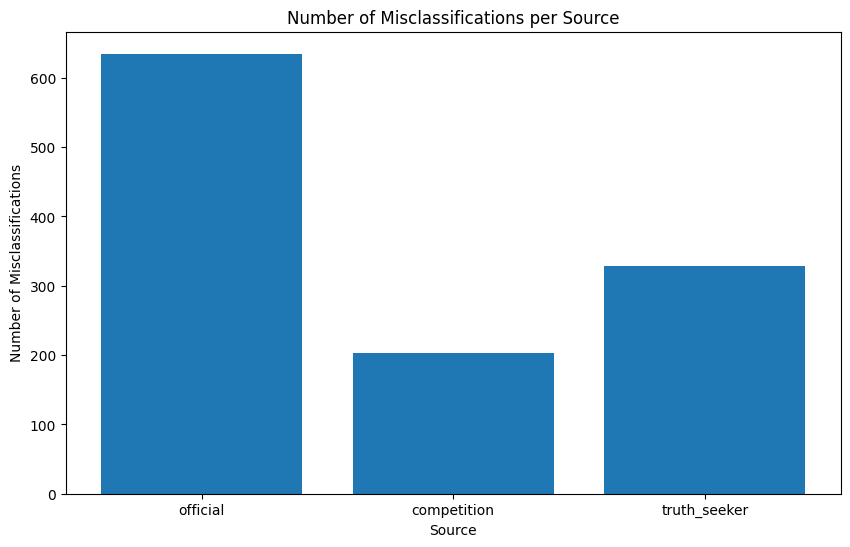

In [221]:
from collections import defaultdict

# Initialize a default dictionary
mismatched_source_counts = defaultdict(int)

# Iterate over mismatched indices
for idx in mismatched_indices:
    original_idx = y_test.index[idx]  # find original index from y_test
    source = feature_df.loc[original_idx, 'source']  # obtain original source
    mismatched_source_counts[source] += 1  # increment the count of this source

# Now let's plot the results
sources = list(mismatched_source_counts.keys())
counts = list(mismatched_source_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(sources, counts)
plt.xlabel('Source')
plt.ylabel('Number of Misclassifications')
plt.title('Number of Misclassifications per Source')
plt.show()

#### Select K Best

SelectKBest is a simple and effective way to perform univariate feature selection in sklearn. It's useful for datasets with many features where you want to reduce the dimensionality by keeping only the most informative features according to a specific criteria

It's important to keep in mind, however, that this method considers each feature individually, 
and so may miss out on important interactions between features.

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Apply the SelectKBest feature selection
fs = SelectKBest(score_func=f_classif, k='all')
X_selected = fs.fit_transform(X_unique, y_unique)

# Get the scores
scores = fs.scores_

# Get the feature names
feature_names = X_unique.columns

# Create a DataFrame with feature names and their corresponding scores
feature_scores_kbest = pd.DataFrame({'Feature': feature_names, 'Score': scores})

# Sort the DataFrame by Score in descending order and reset the index
feature_scores_kbest = feature_scores_kbest.sort_values('Score', ascending=False).reset_index(drop=True)

# Print the DataFrame
print(feature_scores_kbest)


                Feature        Score
0     sentiment_RoBERTa  9876.818616
1               valence  4932.403327
2             dominance  4014.631991
3               novelty  3056.176816
4               arousal  2745.938876
5   average_word_length   521.966133
6          superlatives   410.071660
7           readability   397.967041
8       interestingness   303.117239
9     lexical_diversity    81.761734
10         concreteness     0.456879


In [20]:
# Calculate the total sum of scores
total_score = feature_scores_kbest['Score'].sum()

# Normalize each score by dividing it by the total sum
feature_scores_kbest['Score'] = feature_scores_kbest['Score'] / total_score
feature_scores_kbest

,Feature,Score
0,sentiment_RoBERTa,0.374955
1,valence,0.187250
2,dominance,0.152408
3,novelty,0.116022
4,arousal,0.104245
5,average_word_length,0.019815
6,superlatives,0.015568
7,readability,0.015108
8,interestingness,0.011507
9,lexical_diversity,0.003104


#### Random Forest Selection

In [120]:
# Tree-baed model

# Initialize the model
rf_unique = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_unique.fit(X_train_unique, y_train_unique)

# Use the fitted model to make predictions on the test data
y_pred_unique = rf_unique.predict(X_test_unique)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test_unique, y_pred_unique))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test_unique, y_pred_unique))


Accuracy: 0.843209229155742

Confusion Matrix:
 [[2755  408]
 [ 489 2069]]


In [135]:
# Get feature importances
importances = rf_unique.feature_importances_

# Create a list of (feature, importance) tuples
feature_importances = [(feature, importance) for feature, importance in zip(X_train_unique.columns, importances)]

# Sort the feature importances by most important first
feature_importances_sorted = sorted(feature_importances, key = lambda x: x[1], reverse=True)

# Convert the feature importances into a DataFrame
df_importances = pd.DataFrame(feature_importances_sorted, columns=['Feature', 'Importance'])

# Print the DataFrame
print(df_importances)


                Feature  Importance
0     sentiment_RoBERTa    0.188793
1               valence    0.145148
2             dominance    0.122243
3          concreteness    0.109199
4               arousal    0.103432
5   average_word_length    0.086896
6           readability    0.079691
7     lexical_diversity    0.074676
8               novelty    0.058542
9       interestingness    0.019444
10         superlatives    0.011936


#### Permutation Feature Importance


In [122]:
# Fit model with final features and get accuracy
lsvc.fit(X_train_unique, y_train_unique)
y_pred = lsvc.predict(X_test_unique)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [136]:
from sklearn.inspection import permutation_importance
import pandas as pd

result = permutation_importance(lsvc, X_test_unique, y_test_unique, n_repeats=10, random_state=42, n_jobs=2)

# Get importances and their std
importances_mean = result.importances_mean
importances_std = result.importances_std

# Get feature names
feature_names = X_test_unique.columns.tolist()

# Create a DataFrame with feature names and their corresponding importance scores
feature_importances_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances_mean,
    'Std': importances_std
})

# Sort the DataFrame by Importance in descending order and reset the index
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Print the DataFrame
print(feature_importances_df)


                Feature  Importance       Std
0     sentiment_RoBERTa    0.140640  0.004777
1               novelty    0.040430  0.002854
2               arousal    0.020031  0.002644
3             dominance    0.015277  0.001885
4          concreteness    0.002167  0.000899
5               valence    0.001643  0.001304
6     lexical_diversity    0.001066  0.000772
7          superlatives    0.000996  0.001682
8       interestingness   -0.001049  0.000877
9   average_word_length   -0.001101  0.001013
10          readability   -0.001608  0.002158


In [138]:
# Transform
feature_importances_df.loc[feature_importances_df['Importance'] < 0, 'Importance'] = 0

total_importance = feature_importances_df['Importance'].sum()

feature_importances_df['Importance'] = feature_importances_df['Importance'] / total_importance
feature_importances_df


,Feature,Importance,Std
0,sentiment_RoBERTa,0.632796,0.004777
1,novelty,0.181911,0.002854
2,arousal,0.090130,0.002644
3,dominance,0.068738,0.001885
4,concreteness,0.009752,0.000899
5,valence,0.007393,0.001304
6,lexical_diversity,0.004797,0.000772
7,superlatives,0.004483,0.001682
8,interestingness,0.000000,0.000877
9,average_word_length,0.000000,0.001013


#### Permutation No Novelty (to investigate Interestingnesss)

In [26]:
X_train_unique_no_novelty = X_train_unique.drop('novelty', axis=1)
X_test_unique_no_novelty = X_test_unique.drop('novelty', axis=1)

In [27]:
# Fit model with final features and get accuracy
lsvc.fit(X_train_unique_no_novelty, y_train_unique)
y_pred = lsvc.predict(X_test_unique_no_novelty)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [28]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Calculate
result = permutation_importance(lsvc, X_test_unique_no_novelty, y_test_unique, n_repeats=10, random_state=42, n_jobs=2)

# Get importances and their std
importances_mean = result.importances_mean
importances_std = result.importances_std

# Get feature names
feature_names = X_test_unique_no_novelty.columns.tolist()

# Create a DataFrame with feature names and their corresponding importance scores
feature_importances_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances_mean,
    'Std': importances_std
})

# Sort the DataFrame by Importance in descending order and reset the index
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Print the DataFrame
print(feature_importances_df)


               Feature  Importance       Std
0    sentiment_RoBERTa    0.167016  0.006059
1              arousal    0.021080  0.002373
2            dominance    0.005384  0.000950
3         superlatives    0.002604  0.001179
4      interestingness    0.001468  0.001357
5         concreteness    0.001276  0.001289
6              valence   -0.000699  0.000442
7          readability   -0.001416  0.000533
8    lexical_diversity   -0.002360  0.000759
9  average_word_length   -0.003076  0.000889


In [29]:
# Transform to weights
feature_importances_df.loc[feature_importances_df['Importance'] < 0, 'Importance'] = 0

total_importance = feature_importances_df['Importance'].sum()

feature_importances_df['Importance'] = feature_importances_df['Importance'] / total_importance
feature_importances_df


,Feature,Importance,Std
0,sentiment_RoBERTa,0.840000,0.006059
1,arousal,0.106022,0.002373
2,dominance,0.027077,0.000950
3,superlatives,0.013099,0.001179
4,interestingness,0.007385,0.001357
5,concreteness,0.006418,0.001289
6,valence,0.000000,0.000442
7,readability,0.000000,0.000533
8,lexical_diversity,0.000000,0.000759
9,average_word_length,0.000000,0.000889


#### RF No Novelty

In [30]:
# Tree-baed model

# Initialize the model
rf_unique = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_unique.fit(X_train_unique_no_novelty, y_train_unique)

# Use the fitted model to make predictions on the test data
y_pred_unique = rf_unique.predict(X_test_unique_no_novelty)

# Print the accuracy score
print("Accuracy:", accuracy_score(y_test_unique, y_pred_unique))

# Get feature importances
importances = rf_unique.feature_importances_

# Create a list of (feature, importance) tuples
feature_importances = [(feature, importance) for feature, importance in zip(X_train_unique_no_novelty.columns, importances)]

# Sort the feature importances by most important first
feature_importances_sorted = sorted(feature_importances, key = lambda x: x[1], reverse=True)

# Convert the feature importances into a DataFrame
df_importances = pd.DataFrame(feature_importances_sorted, columns=['Feature', 'Importance'])

# Print the DataFrame
print(df_importances)



Accuracy: 0.8323719629435413
               Feature  Importance
0    sentiment_RoBERTa    0.197849
1              valence    0.140930
2            dominance    0.134344
3         concreteness    0.118736
4              arousal    0.118380
5  average_word_length    0.090627
6          readability    0.082453
7    lexical_diversity    0.079863
8      interestingness    0.023869
9         superlatives    0.012948


# Interestingness

#### Preprocessing

In [20]:
# load in the testing feature_df
feature_df = pd.read_csv('feature_df.csv')

In [21]:
# Select relevant features
feature_df = feature_df[['source','preprocessed','label', 'interestingness', 'sentiment_BERT',
                          'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 
                          'sentiment_vader', 'readability', 'lexical_diversity', 'superlatives', 'novelty', 
                          'average_word_length', 'plausibility', 'concreteness_lexical', 'valence_lexical', 
                          'dominance_lexical', 'arousal_lexical']]

# Select relevant features
feature_df_unique = feature_df[['source','preprocessed','label', 'interestingness',
                          'sentiment_RoBERTa', 'concreteness', 'valence', 'dominance', 'arousal', 
                          'readability', 'lexical_diversity', 'superlatives', 'novelty', 
                          'average_word_length', 'plausibility']]

In [22]:
# 8 times ChatGPT assigned non-existant labels, exclude them 
print(feature_df.isna().sum())
print(len(feature_df))

# 8 times ChatGPT assigned non-existant labels, exclude them 
print(feature_df_unique.isna().sum())
print(len(feature_df_unique))

source                    0
preprocessed              0
label                     0
interestingness           8
sentiment_BERT            0
sentiment_RoBERTa         0
concreteness              0
valence                   0
dominance                 0
arousal                   0
sentiment_vader           0
readability               0
lexical_diversity         0
superlatives              0
novelty                   0
average_word_length       0
plausibility              0
concreteness_lexical     57
valence_lexical         176
dominance_lexical       176
arousal_lexical         176
dtype: int64
28609
source                 0
preprocessed           0
label                  0
interestingness        8
sentiment_RoBERTa      0
concreteness           0
valence                0
dominance              0
arousal                0
readability            0
lexical_diversity      0
superlatives           0
novelty                0
average_word_length    0
plausibility           0
dtype: int64
28609

In [23]:
# Drop NaNs 
feature_df = feature_df.dropna()
print(len(feature_df))

feature_df_unique = feature_df_unique.dropna()
print(len(feature_df_unique))

28425
28601


In [24]:
# Define feature set and target variable
features_interest = feature_df.columns.drop('label').drop('source').drop('preprocessed').drop('interestingness')
X_interest = feature_df[features_interest]
y_interest = feature_df['interestingness']

In [25]:
# Define feature set and target variable
features_interest_unique = feature_df_unique.columns.drop('label').drop('source').drop('preprocessed').drop('interestingness')
X_interest_unique = feature_df_unique[features_interest_unique]
y_interest_unique = feature_df_unique['interestingness']

In [26]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit the encoder and transform y
y_interest = le.fit_transform(y_interest)
y_interest_unique = le.fit_transform(y_interest_unique)

In [27]:
# Split the data into training and testing sets (shuffle by default)
X_train_interest, X_test_interest, y_train_interest, y_test_interest = train_test_split(X_interest,
                                                    y_interest,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

In [28]:
# Split the data into training and testing sets (shuffle by default)
X_train_interest_unique, X_test_interest_unique, y_train_interest_unique, y_test_interest_unique = train_test_split(X_interest_unique,
                                                    y_interest_unique,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

#### Feature Importance

##### Select K Best

In [62]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Apply the SelectKBest feature selection
fs = SelectKBest(score_func=f_classif, k='all')
X_selected = fs.fit_transform(X_interest_unique, y_interest_unique)

# Get the scores
scores = fs.scores_

# Get the feature names
feature_names = X_interest_unique.columns

# Create a DataFrame with feature names and their corresponding scores
feature_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})

# Sort the DataFrame by Score in descending order and reset the index
feature_scores = feature_scores.sort_values('Score', ascending=False).reset_index(drop=True)

# Print the DataFrame
print(feature_scores)


                Feature        Score
0               novelty  3641.763620
1               arousal   852.388698
2          plausibility   533.193682
3               valence   263.272291
4     sentiment_RoBERTa   201.396558
5           readability   136.481851
6             dominance   134.034437
7     lexical_diversity    90.938537
8          concreteness    63.748798
9   average_word_length    53.616779
10         superlatives     5.676365


In [72]:
# Calculate the total sum of scores
total_score = feature_scores['Score'].sum()

# Normalize each score by dividing it by the total sum
feature_scores['Score'] = feature_scores['Score'] / total_score
feature_scores

,Feature,Score
0,novelty,0.609346
1,arousal,0.142623
2,plausibility,0.089215
3,valence,0.044051
4,sentiment_RoBERTa,0.033698
5,readability,0.022836
6,dominance,0.022427
7,lexical_diversity,0.015216
8,concreteness,0.010667
9,average_word_length,0.008971


##### Random Forest

In [92]:
# Tree-based model

from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_interest = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_interest.fit(X_train_interest_unique, y_train_interest_unique)

# Get feature importances
importances = rf_interest.feature_importances_

# Create a list of (feature, importance) tuples
feature_importances = [(feature, importance) for feature, importance in zip(X_train_interest_unique.columns, importances)]

# Sort the feature importances by most important first
feature_importances_sorted = sorted(feature_importances, key = lambda x: x[1], reverse=True)

# Convert the feature importances into a DataFrame
df_importances = pd.DataFrame(feature_importances_sorted, columns=['Feature', 'Importance'])

# Print the DataFrame
print(df_importances)

                Feature  Importance
0               novelty    0.140368
1               arousal    0.134616
2          concreteness    0.119821
3             dominance    0.118952
4               valence    0.118759
5   average_word_length    0.109602
6           readability    0.103712
7     lexical_diversity    0.087397
8          plausibility    0.031227
9     sentiment_RoBERTa    0.025392
10         superlatives    0.010154


##### Permutation

In [70]:
from sklearn.inspection import permutation_importance
import pandas as pd

lsvc = LinearSVC()
lsvc.fit(X_train_interest_unique, y_train_interest_unique)

# Calculate
result = permutation_importance(lsvc, X_test_interest_unique, y_test_interest_unique, n_repeats=10, random_state=42, n_jobs=2)

# Get importances and their std
importances_mean = result.importances_mean
importances_std = result.importances_std

# Get feature names
feature_names = X_test_interest_unique.columns.tolist()

# Create a DataFrame with feature names and their corresponding importance scores
feature_importances_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances_mean,
    'Std': importances_std
})

# Sort the DataFrame by Importance in descending order and reset the index
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Print the DataFrame
print(feature_importances_df)


                Feature  Importance       Std
0               novelty    0.079409  0.002944
1               arousal    0.005139  0.001061
2     sentiment_RoBERTa    0.000717  0.000923
3          plausibility    0.000717  0.000509
4           readability    0.000332  0.000598
5               valence   -0.000175  0.001327
6          superlatives   -0.000297  0.000391
7             dominance   -0.000402  0.000898
8   average_word_length   -0.000420  0.000502
9     lexical_diversity   -0.000594  0.000660
10         concreteness   -0.002098  0.000849


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [73]:
# Transform to weights
feature_importances_df.loc[feature_importances_df['Importance'] < 0, 'Importance'] = 0

total_importance = feature_importances_df['Importance'].sum()

feature_importances_df['Importance'] = feature_importances_df['Importance'] / total_importance
feature_importances_df


,Feature,Importance,Std
0,novelty,0.920008,0.002944
1,arousal,0.059538,0.001061
2,sentiment_RoBERTa,0.008303,0.000923
3,plausibility,0.008303,0.000509
4,readability,0.003848,0.000598
5,valence,0.000000,0.001327
6,superlatives,0.000000,0.000391
7,dominance,0.000000,0.000898
8,average_word_length,0.000000,0.000502
9,lexical_diversity,0.000000,0.000660


#### Baseline

In [86]:
lsvc_interest = LinearSVC(random_state=42)

# Fit model with final features and get accuracy
lsvc_interest.fit(X_train_interest, y_train_interest)
y_pred_interest = lsvc_interest.predict(X_test_interest)

# Use the fitted model to make predictions on the test data
y_pred_interest = lsvc_interest.predict(X_test_interest)

print('Weighted F1:',f1_score(y_test_interest, y_pred_interest, average='weighted'))
print('Micro F1:', f1_score(y_test_interest, y_pred_interest, average='micro'))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test_interest, y_pred_interest))

# Print the classification report
print("\Confusion matrix:\n", confusion_matrix(y_test_interest, y_pred_interest))


Weighted F1: 0.6874722488136321
Micro F1: 0.7477572559366754

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       353
           1       0.75      0.98      0.85      3979
           2       0.77      0.27      0.40      1353

    accuracy                           0.75      5685
   macro avg       0.50      0.42      0.42      5685
weighted avg       0.70      0.75      0.69      5685

\Confusion matrix:
 [[   0  336   17]
 [   1 3883   95]
 [   0  985  368]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Advanced Models

##### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],  # number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt']  # number of features to consider at each split
}

# Initialize the RandomForestClassifier
rf_interest = RandomForestClassifier()

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=rf_interest, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the GridSearchCV
grid_search.fit(X_train_interest, y_train_interest)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best parameters: ", best_params)

# Get the best score
best_score = grid_search.best_score_

# Print the best score
print("Best score: ", best_score)

# Make predictions on the test data
y_pred_interest = grid_search.best_estimator_.predict(X_test_interest)

print('Weighted F1:',f1_score(y_test_interest, y_pred_interest, average='weighted'))
print('Micro F1:', f1_score(y_test_interest, y_pred_interest, average='micro'))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test_interest, y_pred_interest))

# Print the classification report
print("\Confusion matrix:\n", confusion_matrix(y_test_interest, y_pred_interest))



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Best parameters:  {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best score:  0.77207563764292
Weighted F1: 0.7460703981273166
Micro F1: 0.7773087071240106

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.18      0.29       353
           1       0.78      0.95      0.86      3979
           2       0.75      0.41      0.53      1353

    accuracy                           0.78      5685
   macro avg       0.76      0.51      0.56      5685
weighted avg       0.77      0.78      0.75      5685

\Confusion matrix:
 [[  62  267   24]
 [  18 3799  162]
 [   2  793  558]]


##### XGBoost

In [30]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define our XGBClassifier with default hyperparameters
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define our parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01],  # commonly used values
    'max_depth': [3, 10],  # lower bound and upper bound
    'min_child_weight': [1, 5],  # lower bound and upper bound
    'gamma': [0, 0.2],  # default is 0, let's try adding some regularization
    'subsample': [0.5, 1.0],  # lower bound and upper bound
    'colsample_bytree': [0.6, 1.0]  # lower bound and upper bound
}

# Initialize GridSearchCV
grid_cv = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Fit the GridSearchCV
grid_cv.fit(X_train_interest, y_train_interest)

# Print best parameters and results
print(f"Best parameters: {grid_cv.best_params_}")
print(f"Best score: {grid_cv.best_score_}")


Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.5; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.5; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5; total time=

In [31]:
# Make predictions on the test data
y_pred_interest = grid_cv.best_estimator_.predict(X_test_interest)

print('Weighted F1:',f1_score(y_test_interest, y_pred_interest, average='weighted'))
print('Micro F1:', f1_score(y_test_interest, y_pred_interest, average='micro'))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test_interest, y_pred_interest))

# Print the classification report
print("\Confusion matrix:\n", confusion_matrix(y_test_interest, y_pred_interest))


Weighted F1: 0.747795823441175
Micro F1: 0.7725593667546174

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.20      0.31       353
           1       0.79      0.93      0.85      3979
           2       0.70      0.45      0.55      1353

    accuracy                           0.77      5685
   macro avg       0.72      0.53      0.57      5685
weighted avg       0.76      0.77      0.75      5685

\Confusion matrix:
 [[  72  258   23]
 [  26 3712  241]
 [   9  736  608]]


##### XGBoost (Macro-f1)

In [37]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define our XGBClassifier with default hyperparameters
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define our parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01],  # commonly used values
    'max_depth': [3, 10],  # lower bound and upper bound
    'min_child_weight': [1, 5],  # lower bound and upper bound
    'gamma': [0, 0.2],  # default is 0, let's try adding some regularization
    'subsample': [0.5, 1.0],  # lower bound and upper bound
    'colsample_bytree': [0.6, 1.0]  # lower bound and upper bound
}

# Initialize GridSearchCV
grid_cv = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=3)

# Fit the GridSearchCV
grid_cv.fit(X_train_interest, y_train_interest)

# Print best parameters and results
print(f"Best parameters: {grid_cv.best_params_}")
print(f"Best score: {grid_cv.best_score_}")

# Make predictions on the test data
y_pred_interest = grid_cv.best_estimator_.predict(X_test_interest)

print('Weighted F1:',f1_score(y_test_interest, y_pred_interest, average='weighted'))
print('Micro F1:', f1_score(y_test_interest, y_pred_interest, average='micro'))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test_interest, y_pred_interest))

# Print the classification report
print("\Confusion matrix:\n", confusion_matrix(y_test_interest, y_pred_interest))



Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 3/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5;, score=0.516 total time=   3.2s
[CV 2/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.504 total time=   3.2s
[CV 1/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.5;, score=0.525 total time=   3.2s
[CV 2/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.5;, score=0.506 total time=   3.3s
[CV 1/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5;, score=0.524 total time=   3.3s
[CV 2/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.5;, score=0.506 total time=   3.5s
[CV 1/3] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.520 total time=   3.6s

##### Linear SVM


In [33]:
# Define the parameter grid
param_grid = {'C': [0.001, 0.1, 10, 1000]}

# Create a SVC model
svc = LinearSVC()

# Use Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create the GridSearchCV model
grid_search = GridSearchCV(svc, param_grid, cv=cv, verbose=3, n_jobs=-1, scoring='f1_weighted')

# Fit the model
grid_search.fit(X_train_interest, y_train_interest)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")

# Make predictions on the test data
y_pred_interest = grid_search.best_estimator_.predict(X_test_interest)

print('Weighted F1:',f1_score(y_test_interest, y_pred_interest, average='weighted'))
print('Micro F1:', f1_score(y_test_interest, y_pred_interest, average='micro'))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test_interest, y_pred_interest))

# Print the classification report
print("\Confusion matrix:\n", confusion_matrix(y_test_interest, y_pred_interest))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 2/3] END ...........................C=0.001;, score=0.683 total time=   0.2s
[CV 1/3] END ...........................C=0.001;, score=0.680 total time=   0.3s
[CV 3/3] END ...........................C=0.001;, score=0.685 total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END .............................C=0.1;, score=0.689 total time=   4.4s
[CV 3/3] END .............................C=0.1;, score=0.690 total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END .............................C=0.1;, score=0.686 total time=   4.8s
[CV 3/3] END ..............................C=10;, score=0.585 total time=   4.7s
[CV 2/3] END ..............................C=10;, score=0.700 total time=   4.8s
[CV 1/3] END ..............................C=10;, score=0.617 total time=   4.9s
[CV 1/3] END ............................C=1000;, score=0.654 total time=   4.7s
[CV 2/3] END ............................C=1000;, score=0.565 total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END ............................C=1000;, score=0.627 total time=   2.5s
Best parameters: {'C': 0.1}
Best score: 0.6883678690181245
Weighted F1: 0.6849773163422127
Micro F1: 0.7461741424802112

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       353
           1       0.75      0.98      0.84      3979
           2       0.76      0.27      0.39      1353

    accuracy                           0.75      5685
   macro avg       0.50      0.41      0.41      5685
weighted avg       0.70      0.75      0.68      5685

\Confusion matrix:
 [[   0  335   18]
 [   0 3883   96]
 [   0  994  359]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn

##### Kernalized SVM

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {'C': [0.1, 10, 1000], 
              'gamma': [0.1, 0.001],
              'kernel': ['rbf']}

# Create a SVC model
svc = SVC(probability=True)

# Use Stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create the GridSearchCV model
grid_search = GridSearchCV(svc, param_grid, cv=cv, verbose=3, n_jobs=-1, scoring='f1_weighted')

# Fit the model
grid_search.fit(X_train_interest, y_train_interest)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best score
best_score = grid_search.best_score_
print(f"Best score: {best_score}")




Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 2/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.668 total time=  57.4s
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.664 total time=  57.8s
[CV 2/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.580 total time= 1.0min
[CV 1/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.580 total time= 1.0min
[CV 3/3] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.580 total time= 1.0min
[CV 3/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.659 total time= 1.1min
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.718 total time= 1.1min
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.712 total time= 1.3min
[CV 1/3] END .....C=10, gamma=0.001, kernel=rbf;, score=0.675 total time= 1.0min
[CV 2/3] END .....C=10, gamma=0.001, kernel=rbf;, score=0.673 total time=  59.2s
[CV 3/3] END .....C=10, gamma=0.001, kernel=rbf;, score=0.670 total time=  59.6s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;,

In [36]:
# Make predictions on the test data
y_pred_interest = grid_search.best_estimator_.predict(X_test_interest)

print('Weighted F1:',f1_score(y_test_interest, y_pred_interest, average='weighted'))
print('Micro F1:', f1_score(y_test_interest, y_pred_interest, average='micro'))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test_interest, y_pred_interest))

# Print the classification report
print("\Confusion matrix:\n", confusion_matrix(y_test_interest, y_pred_interest))

Weighted F1: 0.7117120143186003
Micro F1: 0.7542656112576956

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.13      0.22       353
           1       0.76      0.96      0.85      3979
           2       0.73      0.32      0.44      1353

    accuracy                           0.75      5685
   macro avg       0.70      0.47      0.50      5685
weighted avg       0.74      0.75      0.71      5685

\Confusion matrix:
 [[  47  288   18]
 [  26 3812  141]
 [   3  921  429]]
